# Use OffPAC to Play Acrobot-v1

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
torch.manual_seed(0)

imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('Acrobot-v1')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

20:35:40 [INFO] env: <AcrobotEnv<Acrobot-v1>>
20:35:40 [INFO] action_space: Discrete(3)
20:35:40 [INFO] observation_space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
20:35:40 [INFO] reward_range: (-inf, inf)
20:35:40 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 15}
20:35:40 [INFO] _max_episode_steps: 500
20:35:40 [INFO] _elapsed_steps: None


In [3]:
class OffPACAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.actor_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,],
                output_size=env.action_space.n, output_activator=nn.Softmax(1))
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), 0.0002)
        self.critic_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,], output_size=self.action_n)
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), 0.0004)
        self.critic_loss = nn.MSELoss()

    def build_net(self, input_size, hidden_sizes, output_size,
            output_activator=None):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        net = nn.Sequential(*layers)
        return net

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []
            self.discount = 1.

    def step(self, observation, reward, done):
        if self.mode == 'train':
            action = np.random.choice(self.action_n)
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                self.learn()
            self.discount *= self.gamma
        else:
            state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
            prob_tensor = self.actor_net(state_tensor)
            action_tensor = distributions.Categorical(prob_tensor).sample()
            action = action_tensor.numpy()[0]
        return action

    def close(self):
        pass

    def learn(self):
        state, _, _, action, next_state, reward, done, next_action = \
                self.trajectory[-8:]
        state_tensor = torch.as_tensor(state, dtype=torch.float).unsqueeze(0)
        next_state_tensor = torch.as_tensor(state, dtype=torch.float).unsqueeze(0)

        # train actor
        q_tensor = self.critic_net(state_tensor)[0, action]
        pi_tensor = self.actor_net(state_tensor)[0, action]
        behavior_prob = 1. / self.action_n
        actor_loss_tensor = -self.discount * q_tensor / behavior_prob * pi_tensor
        self.actor_optimizer.zero_grad()
        actor_loss_tensor.backward()
        self.actor_optimizer.step()

        # train critic
        next_q_tensor = self.critic_net(next_state_tensor)[:, next_action]
        target_tensor = reward + (1. - done) * self.gamma * next_q_tensor
        pred_tensor = self.critic_net(state_tensor)
        critic_loss_tensor = self.critic_loss(pred_tensor, target_tensor)
        pi_tensor = self.actor_net(state_tensor)[0, action]
        ratio_tensor = pi_tensor / behavior_prob # importance sampling ratio
        critic_loss_tensor *= ratio_tensor
        self.critic_optimizer.zero_grad()
        critic_loss_tensor.backward()
        self.critic_optimizer.step()


agent = OffPACAgent(env)

20:35:41 [INFO] ==== train ====
20:35:44 [DEBUG] train episode 0: reward = -500.00, steps = 500
20:35:46 [DEBUG] train episode 1: reward = -500.00, steps = 500
20:35:49 [DEBUG] train episode 2: reward = -500.00, steps = 500
20:35:52 [DEBUG] train episode 3: reward = -500.00, steps = 500
20:35:55 [DEBUG] train episode 4: reward = -500.00, steps = 500
20:35:57 [DEBUG] train episode 5: reward = -500.00, steps = 500
20:36:00 [DEBUG] train episode 6: reward = -500.00, steps = 500
20:36:03 [DEBUG] train episode 7: reward = -500.00, steps = 500
20:36:05 [DEBUG] train episode 8: reward = -500.00, steps = 500
20:36:08 [DEBUG] train episode 9: reward = -500.00, steps = 500
20:36:11 [DEBUG] train episode 10: reward = -500.00, steps = 500
20:36:13 [DEBUG] train episode 11: reward = -500.00, steps = 500
20:36:16 [DEBUG] train episode 12: reward = -500.00, steps = 500
20:36:18 [DEBUG] train episode 13: reward = -500.00, steps = 500
20:36:21 [DEBUG] train episode 14: reward = -500.00, steps = 500
20:

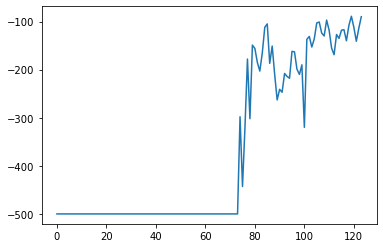

In [4]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -120:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [5]:
env.close()